## PSO Tuning for PID-PD controller

references :
 - [1] Solihin, M. I., Wahyudi, Kamal, M. A. S., & Legowo, A. (2008). Optimal PID controller tuning of automatic gantry crane using PSO algorithm. In 2008 5th International Symposium on Mechatronics and Its Applications (pp. 1–5).

 - [2] Iffah, M. A. N., Nafrizuan, M. Y., Ho, J. F., & Azhar, W. Y. W. (2019). Optimization of the PID-PD parameters of the overhead crane control system by using PSO algorithm. MATEC Web of Conferences, 255, 4001.

##Import Library

In [2]:
# library install
!pip install control
!pip install ipython-autotime
%load_ext autotime

# package install
import numpy as np
from control import *
from control.matlab import *
import matplotlib.pyplot as plt

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.84 s (started: 2021-04-19 01:06:19 +07:00)


## Gantry Crane Model

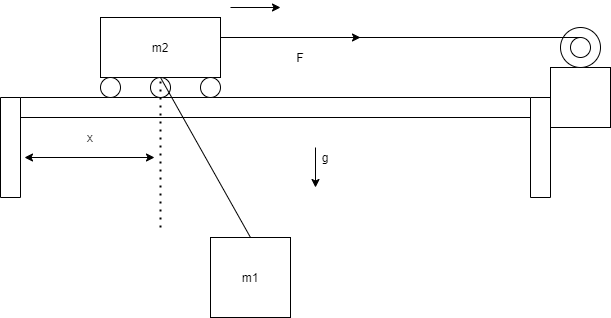




In [39]:
#gantry model

#parameters
m1 = 1            #payload
m2 = 1.5          #trolley
l = 0.5           #rope length
g = 9.81          #gravitational acceleration
D = 12.32         #damping constant
R = 0.5           #motor resistant
Kt = 0.0071619    #torque constant
Ke = 0.0071619    #electric constant
rp = 0.012        #pulley radius
r = 1             #gear ratio

#state space representation
a = ((R*rp)/(Kt*r))*(m1+m2)
b = ((Ke*r)/(rp))+((D*R*rp)/(Kt*r))
c = ((m1*l*R*rp)/(Kt*r))

a22 = (-b)/(a -(c/l))
a23 = (c*g)/(l*(a-(c/l)))
a42 = (b)/(a*(l-(c/a)))
a43 = (-g)/(l-(c/a))

b21 = 1/(a-(c/l))
b41 = (-1)/(a*(l-(c/a)))

A = [[0,1,0,0],
     [0,a22,a23,0],
     [0,0,0,1],
     [0,a42,a43,0]]

B = [[0],
     [b21],
     [0],
     [b41]]

Cp = [1,0,0,0]
Cs = [0,0,1,0]

D = [0]

ss_pos = ss(A,B,Cp,D)
ss_swy = ss(A,B,Cs,D)
tf_pos = tf(ss_pos)
tf_swy = tf(ss_swy)

tf_sys = [tf_pos,tf_swy]

time: 0 ns (started: 2021-04-19 01:19:00 +07:00)


##Closed Loop System

In [40]:
# Closed loop system
# Input argument :
# param : [Kp,Ki,Kd,Kps,Kds] (1x5 list)
# tf_sys : [tf_pos,tf_swy] (1x2 list)
# t_sim : (1xn list) or simulation duration

def closed_loop(param,tf_sys,t_sim): 
    pos,swy = tf_sys # pos: position transfer function, swy: sway transfer function

    Kp, Ki, Kd, Kps, Kds = param # Kp,Ki,Kd (position PID controller); Kps, Kds (sway angle PD controller)

    pid = tf([Kd, Kp, Ki],[1,0]) # position PID controller
    pd = tf([Kds,Kps],1) # sway angle PD controller

    #This is a SIMO system (Single Input Multiple Output), divide the output transfer function
    #to make it easier for simulation
    #Position Output
    feedblk1 = feedback(1,(pd*swy),sign=1) 
    pos_blk = feedback(pid*feedblk1*pos,1,sign=-1)
    [yp,_] = step(pos_blk,t_sim) 

    #Sway Output
    feedblk2 = feedback(1,pos*pid,sign=-1)
    feedblk3 = feedback(feedblk2*swy,pd,sign=1)
    swy_blk = pid*feedblk3
    [ys,_] = step(swy_blk,t_sim)

    #routh stability criterion
    # real poles < 0 == stable
    poles_p = pole(pos_blk)
    for i in poles_p.real:
        if i > 0:
            return False
        else:
            poles_s = pole(swy_blk)
            for i in poles_s.real:
                if i > 0:
                    return False

    return [yp,ys]

time: 16 ms (started: 2021-04-19 01:19:04 +07:00)


## Trajecotry Reference

SSE = 7.467358866275475e-05 , SettlingTime = 4.24, RiseTime = 2.6, Oveshoot = 0.0


Text(0.5, 1.0, 'X reference model')

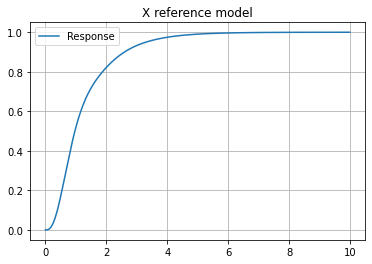

time: 94 ms (started: 2021-04-19 01:19:19 +07:00)


In [41]:
# refernce trajectory (step signal)
def step_signal(value,time):
    signal = np.zeros_like(time)
    signal[time>=0] = 1
    return value*signal

#x_ref model 3th order ITAE
#still editable and needs some check and validation
damp_rat = 0.7         #damping ratio
Ts = 1.7                   
w = 4/(damp_rat*Ts)
num = w**3
den = [1,1.75*w, 2.15*w**2, 1.5*w**3]
x_ref_tf = tf(num,den)
x_ref_sys = feedback(x_ref_tf,-1)

t_sim = np.arange(0,10,0.01)


[x_ref,_] = step(0.5*x_ref_sys,t_sim)  #simulating trajectory

#step info
SSE_x = abs(1 - x_ref[-1])
OS_x = (x_ref.max()/x_ref[-1]-1) #overshoot
Tr_x= t_sim[next(i for i in range(0,len(x_ref)-1) if x_ref[i]>x_ref[-1]*.90)]-t_sim[0] #rise time
try:
    Ts_x = t_sim[next(len(x_ref)-i for i in range(2,len(x_ref)-1) if abs(x_ref[-i]/x_ref[-1])<0.98)]-t_sim[0]
except StopIteration :
    eval_pos = False

print("SSE = {a} , SettlingTime = {b}, RiseTime = {c}, Oveshoot = {d}".format(a = SSE_x,b = Ts_x, c = Tr_x , d = OS_x))

plt.plot(t_sim,x_ref,label='Response')
plt.legend()
plt.grid()
plt.title('X reference model')

##Cost

In [42]:
#Cost Function 
def cost_func(x_ref,yp,ys,t):

    #cost function reference [1]
    dt = t[1]-t[0]

    t1 = 2.6     #rise time
    t2 = 4.24    #settling time

    idx1 = np.where(t==t1)[0][0]
    idx2 = np.where(t==t2)[0][0]

    #initial stage
    #ITSE performance index
    init_stage = np.multiply(t[0:idx1],(yp[0:idx1]-x_ref[0:idx1])**2)*dt
    j_initial = sum(init_stage)

    #sway cancelation
    swy_stage = np.multiply(t[idx1:-1],(ys[idx1:-1])**2)*dt
    j_cancel = sum(swy_stage)

    #final stage
    final_stage = np.multiply(t[idx2:-1],(yp[idx2:-1]-x_ref[idx2:-1])**2)*dt
    j_final = sum(final_stage)

    #total cost
    j = j_initial + j_cancel + j_final

    return j

time: 0 ns (started: 2021-04-19 01:19:21 +07:00)


##Generate Particles and Initialize Boundaries

In [43]:
def generate_population(var_size,position_bound,speed_bound):
    """
    Generating random position and speed vector for each particles.
    var_size is an array with dimension of (total population, n-dimension based on parameters)
    position_bound is an array with indicate the upper bound and lower bound of the parameter position
    speed_bound same as position, but this bound are for speed vector
    """
    particle_position = np.zeros(var_size)
    particle_velocity = np.zeros(var_size)

    for i in range(var_size[0]):
        for j in range(var_size[1]):
            lim = position_bound[j]
            v_lim = speed_bound[j]
            particle_position[i][j] = np.random.uniform(lim[0], lim[1])     
            particle_velocity[i][j] = np.random.uniform(v_lim[0], v_lim[1])

    particle_cost = np.zeros([np.array(particle_position).shape[0],1])

    return [particle_position,particle_velocity,particle_cost]

time: 0 ns (started: 2021-04-19 01:19:22 +07:00)


In [44]:
def parameter_bound(par_val, par_range):
  """
  Adjust generated parameter according to parameter range/boundaries
  par_val: parameter value (type: array, size=1xn)
  par_range: each parameter range (type: array, size=nx2)
  """
  for i in range(np.shape(par_val)[0]):
    if par_val[i]<par_range[i][0]:
        par_val[i]=par_range[i][0]
    elif par_val[i]>par_range[i][1]:
        par_val[i]=par_range[i][1]
  
  return par_val

time: 0 ns (started: 2021-04-19 01:19:24 +07:00)


#PSO

##Initialize

In [45]:
"""
In this system we use 2 controllers, PID for position control and PD for sway control
we need to define 5 position boundaries for 5 parameters (Kp,Ki,Kd,Kps,Kds) and
5 speed vector boundaries for each position
"""
"""
r_kp = [5, 90]        #position bound for parameter Kp
r_ki = [-5, 5 ]       #                             Ki
r_kd = [-10, 50]      #                             Kd
r_kps = [5, 90]       #                             Kps
r_kds = [-10, 50]     #                             Kds
"""
r_kp = [-50, 200]        #position bound for parameter Kp
r_ki = [-50, 50 ]       #                             Ki
r_kd = [-50, 100]      #                             Kd
r_kps = [-50, 200]       #                             Kps
r_kds = [-50, 100]     #                             Kds

gain_bound = [r_kp, r_ki, r_kd, r_kps, r_kds]

speed_bound = np.zeros(np.shape(gain_bound))

for i in range(len(gain_bound)):
    v_lim = (gain_bound[i][1] - gain_bound[i][0])*0.01
    speed_bound[i][0] = -v_lim
    speed_bound[i][1] = v_lim

time: 0 ns (started: 2021-04-19 01:19:27 +07:00)


##Main Loop

In [55]:
"""
n_pop is an integer for defining a total population of the particles
n_sim is an integer for defining a total simulation of the optimisation
iter ia an integer for defining maximum iteration for optimising particles position
"""
n_pop = 20   #total population of the particles
n_sim = 5     #total simulation of the optimisation
iter = 500    #maximum iteration for each optimisation process


global_best_history = np.zeros([n_sim,5]) #array to save the global best position for each simulation
best_cost_history = np.zeros([n_sim,1])  #array to save the best cost for each simulation

for sim in range(n_sim):
    print('Optimisation = {} -----------------------------------------------'.format(sim+1))

    var_size = [n_pop,5] #array dimension (total population, n_parameters)

  #generating populations
    particle_position,particle_velocity,particle_cost = generate_population(var_size,gain_bound,speed_bound)
    particle_pbest = np.copy(particle_position)

  #PSO Parameters
    w_max = 0.9
    w_min = 0.4
    w = 0.9           #inersia weight
    c1 = 2            #cognition weight
    c2 = 2            #social weight

  #First EValuation
    for i in range(n_pop):
        cl_sim = closed_loop(particle_position[i],tf_sys,t_sim)
        if cl_sim == False:
            particle_cost[i] = np.Inf
        else : 
            [yp,ys] = cl_sim
            cost = cost_func(x_ref,yp,ys,t_sim)
            particle_cost[i] = np.copy(cost)

    best_cost = min(particle_cost)        #first best cost for benchmark
    idx_gbest = np.argmin(particle_cost)
    particle_gbest = np.copy(particle_pbest[idx_gbest]) #first gbest position
  
  #Optimisation
    for it in range(iter):
        for i in range(n_pop):
            #Update Velocity
            particle_velocity[i] = \
            w*particle_velocity[i] + \
            c1*np.multiply(np.random.rand(var_size[1]),(particle_pbest[i]-particle_position[i])) + \
            c2*np.multiply(np.random.rand(var_size[1]),(particle_gbest-particle_position[i]))

            #Velocity Boundaries
            particle_velocity[i] = parameter_bound(particle_velocity[i],speed_bound)

            #Update Position
            particle_position[i] = particle_position[i] + particle_velocity[i]

            #Position Boundaries
            particle_position[i] = parameter_bound(particle_position[i],gain_bound)


            cl_sim = closed_loop(particle_position[i],tf_sys,t_sim)

            if cl_sim == False:
                cost = np.Inf
            else : 
                [yp,ys] = cl_sim
                cost = cost_func(x_ref,yp,ys,t_sim)

              #Update Pbest
            if cost < particle_cost[i]:
                particle_cost[i] = np.copy(cost)
                particle_pbest[i] = np.copy(particle_position[i]) #updating pbest

            if cost < best_cost:
                best_cost = np.copy(cost)    #updating gbest
                particle_gbest = np.copy(particle_pbest[i])


            w = w_max -(((w_max-w_min)/iter)*it) #the inertia weight gradually decreased for each iteration

            #if (it+1) % 500 ==0 or (it+1)==1:
            #if (it+1) % 200 ==0 or (it+1)==1:
        if (it+1) % 100 ==0 or (it+1)==1:
            print('Iterasi = {a} || Best Cost = {b}'.format(a=it+1,b=best_cost))

    best_cost_history[sim] = best_cost
    global_best_history[sim] = particle_gbest

Optimisation = 1 -----------------------------------------------
Iterasi = 1 || Best Cost = [0.38921908]
Iterasi = 100 || Best Cost = 0.004109264671777974
Iterasi = 200 || Best Cost = 0.0019174183330102315
Iterasi = 300 || Best Cost = 0.0017349893477206118
Iterasi = 400 || Best Cost = 0.001711773087252464
Iterasi = 500 || Best Cost = 0.0016549702312296146
Optimisation = 2 -----------------------------------------------
Iterasi = 1 || Best Cost = [1.17406135]
Iterasi = 100 || Best Cost = 0.005824446325160101
Iterasi = 200 || Best Cost = 0.001738182085876082
Iterasi = 300 || Best Cost = 0.0017258346796701722
Iterasi = 400 || Best Cost = 0.001688172890091755
Iterasi = 500 || Best Cost = 0.001591886522327038
Optimisation = 3 -----------------------------------------------
Iterasi = 1 || Best Cost = [0.3674344]
Iterasi = 100 || Best Cost = 0.016468844278154978
Iterasi = 200 || Best Cost = 0.0024819072437719915
Iterasi = 300 || Best Cost = 0.0017387779271491727
Iterasi = 400 || Best Cost = 0

In [56]:
particle_position

array([[ 8.72614054e+00,  8.21720644e-03,  5.27113673e+00,
         6.58794784e+01,  1.21882688e+01],
       [ 8.81774272e+00,  8.63143040e-03,  4.98331394e+00,
         5.77034332e+01,  1.16705509e+01],
       [ 8.75274896e+00,  1.13430785e-02,  5.65213950e+00,
         5.91893261e+01,  1.08272714e+01],
       [ 4.99560953e+01, -2.04463628e+01, -6.64374540e+00,
         2.70842470e+01,  4.92487246e+01],
       [ 8.75091513e+00,  8.26936106e-03,  5.16861227e+00,
         5.66042839e+01,  1.07949128e+01],
       [ 8.73869743e+00,  7.43277648e-03,  5.24979226e+00,
         5.72665898e+01,  1.05483257e+01],
       [ 8.75236084e+00,  6.10322219e-03,  5.27966813e+00,
         5.73381437e+01,  1.07527167e+01],
       [ 8.89103473e+01, -2.33674360e+01,  3.57303051e+01,
         1.27630710e+02, -2.20474036e+01],
       [ 8.75095077e+00,  9.58460154e-03,  5.22008788e+00,
         5.72494472e+01,  1.08148504e+01],
       [-7.27398536e-01, -2.00250800e+01, -3.07342056e+00,
         1.32130106e+02

time: 16 ms (started: 2021-04-19 05:02:38 +07:00)


In [23]:
print('Best Solution = {} || Best Cost = {}'.format(global_best_history[np.argmin(best_cost_history)],np.min(best_cost_history)))

Best Solution = [8.72335242e+00 7.34558649e-03 4.32397602e+00 4.66974064e+01
 9.04354876e+00] || Best Cost = 0.0014367029122505162


In [50]:
cl_sim

False

time: 16 ms (started: 2021-04-19 01:21:03 +07:00)


Cost = 0.0014367029122505162


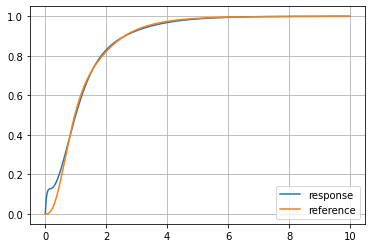

In [20]:
[yp,ys]= closed_loop(global_best_history[np.argmin(best_cost_history)],tf_sys,t_sim)
cost = cost_func(x_ref,yp,ys,t_sim)
plt.plot(t_sim,yp,label='response')
plt.plot(t_sim,x_ref,label='reference')
plt.legend()
plt.grid()
print('Cost = {}'.format(cost))
plt.show()

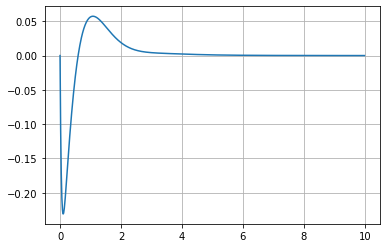

In [21]:
plt.plot(t_sim,ys)
plt.grid()
plt.show()

In [ ]:
# gbest = [9.96186034845010,-8.15393309672183e-05,1.51385611590059,24.0704529339787,2.64092089697622]
gbest = [ 1.60914506e+01,  1.73120981e-02,  9.77248465e+00,
         4.01660194e+01, -1.14786706e+00]

In [ ]:
u = step_signal(1.28,t_sim-0.5)-step_signal(1.28,t_sim-4)+step_signal(1,t_sim-6)-step_signal(0.5,t_sim-8)+step_signal(0.2,t_sim-10)
[yp,ys] = closed_loop(particle_gbest,tf_sys,t_sim) #PSO
[yp2,ys2] = closed_loop(gbest,tf_sys,t_sim) #SFS
dif_blk = tf([1,0],[1])
[yout,tout,x]= lsim(pos_blk,u,t)
[yout2,tout2,x2]= lsim(pos_blk2,u,t)
#yan = cumtrapz(yout,tout)
#plt.plot(tout[0:149],yan)
plt.plot(tp,yp,label='PSO')
plt.plot(tp2,yp2, label ='SFS')
#plt.plot(tout,yout)
#plt.plot(tout,u)
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(tp,ys,label='PSO')
plt.plot(tp2,ys2,label='SFS')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(tout,yout,label='PSO')
plt.plot(tout2,yout2,label='SFS')
plt.plot(tout,u,label='Input')
plt.legend()
plt.grid()
plt.show()

In [ ]:
[ysout,tsout,xs]= lsim(swy_blk,u,t)
#yan = cumtrapz(yout,tout)
#plt.plot(tout[0:149],yan)
plt.plot(tsout,ysout)
plt.plot(tsout,u)
plt.grid()
plt.show()

In [ ]:
pzmap(swy_blk)

In [ ]:
A = pole(swy_blk)

In [ ]:
pos,swy = tf_sys

Kp, Ki, Kd, Kps, Kds = particle_gbest

pid = tf([Kd, Kp, Ki],[1,0])
pd = tf([Kd,Kp],1)

#Position Output
feedblk1 = feedback(1,(pd*swy),sign=1)
pos_blk = feedback(pid*feedblk1*pos,1,sign=-1)
[yp,t] = step(pos_blk,t_sim) 

#Sway Output
feedblk2 = feedback(1,pos*pid,sign=-1)
feedblk3 = feedback(feedblk2*swy,pd,sign=1)
swy_blk = pid*feedblk3
[ys,t] = step(swy_blk,t_sim)

In [ ]:
plt.plot(t,yp)
plt.grid()


In [ ]:
plt.plot(t,ys)

In [ ]:
#Position Output
feedblk1 = feedback(1,(pd*swy),sign=1)
pos_blk = feedback(pid*feedblk1*pos,1,sign=-1)
[yp,t] = step(pos_blk,t_sim,X0=1) 

#Sway Output
feedblk2 = feedback(1,pos*pid,sign=-1)
feedblk3 = feedback(feedblk2*swy,pd,sign=1)
swy_blk = pid*feedblk3
[ys,t] = step(swy_blk,t_sim)

In [ ]:
[yp,ys,t] = closed_loop(gbest,tf_sys,t_sim)
plt.plot(t,yp)
plt.grid()
plt.title('Posisi Crane')
plt.xlim([0,10])
plt.ylim([0,1.1])

In [ ]:
yp